In [1]:
!pip install kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 1.4 MB/s eta 0:00:0000:01
  Preparing metadata (setup.py) ... done
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)
  Created wheel for kaggle: filename=kaggle-1.6.14-py3-none-any.whl size=105119 sha256=bb555f333b2c8ab0d1e1fb75bb5c7ccf793945107bb026b1bd0dcd763d2e9e17
  Stored in directory: /Users/samir/Library/Caches/pip/wheels/ec/d9/04/93be57edf3835182a8e76d8ff87f7e77a0113f473ba3721ee0
Successfully built kaggle
cp: kaggle.json: No such file or directory
chmod: /Users/samir/.kaggle/kaggle.json: No such file or directory


In [2]:
!kaggle datasets download -d haithem1999/prostate-annotated-dataset-for-image-segmentation
!unzip prostate-annotated-dataset-for-image-segmentation.zip

Dataset URL: https://www.kaggle.com/datasets/haithem1999/prostate-annotated-dataset-for-image-segmentation
License(s): unknown
100%|█████████████████████████████████████████| 238M/238M [02:29<00:00, 804kB/s]
100%|████████████████████████████████████████| 238M/238M [02:29<00:00, 1.67MB/s]
Archive:  prostate-annotated-dataset-for-image-segmentation.zip
  inflating: Task05_Prostate/dataset.json  
  inflating: Task05_Prostate/imagesTr/prostate_00.nii  
  inflating: Task05_Prostate/imagesTr/prostate_01.nii  
  inflating: Task05_Prostate/imagesTr/prostate_02.nii  
  inflating: Task05_Prostate/imagesTr/prostate_04.nii  
  inflating: Task05_Prostate/imagesTr/prostate_06.nii  
  inflating: Task05_Prostate/imagesTr/prostate_07.nii  
  inflating: Task05_Prostate/imagesTr/prostate_10.nii  
  inflating: Task05_Prostate/imagesTr/prostate_13.nii  
  inflating: Task05_Prostate/imagesTr/prostate_14.nii  
  inflating: Task05_Prostate/imagesTr/prostate_16.nii  
  inflating: Task05_Prostate/imagesTr/prost

In [4]:
!pip install nibabel

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 1.4 MB/s eta 0:00:0000:0100:010m


In [5]:
import os
import numpy as np
import nibabel as nib
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from scipy.ndimage import zoom


def resize_image(img, target_shape):
    factors = [target_shape[i] / img.shape[i] for i in range(2)]
    return zoom(img, factors, order=1)

def load_nifti_file(filepath):
    img = nib.load(filepath)
    img_data = img.get_fdata()
    return img_data

# Example of loading images and labels
images = []  # List to store image data
labels = []  # List to store label data

image_dir = 'Task05_Prostate/imagesTr'
label_dir = 'Task05_Prostate/labelsTr'


image_files = sorted([os.path.join(image_dir, f) for f in os.listdir(image_dir)])
label_files = sorted([os.path.join(label_dir, f) for f in os.listdir(label_dir)])
target_shape = (128, 128)

for img_file, lbl_file in zip(image_files, label_files):
    img_data = load_nifti_file(img_file)
    lbl_data = load_nifti_file(lbl_file)
    # Extract slices from the first set ([:, :, :, 0] for images)
    img_slices = img_data[:, :, :, 0]
    # Concatenate the slices into the lists
    for i in range(img_slices.shape[2]):
        img_slice = resize_image(img_slices[:, :, i], target_shape)
        images.append(img_slice)
        lbl_slice = resize_image(lbl_data[:, :, i], target_shape)
        labels.append(lbl_slice)


images = np.array(images)
labels = np.array(labels)

# Normalize images
images = images / np.max(images)

# Convert labels to categorical (one-hot encoding)
labels = to_categorical(labels, num_classes=3)  # Assuming 3 classes: background, class 1, class 2

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [6]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras import layers, models
from tensorflow.keras.models import Model
def create_unet_model(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encodage
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = layers.Dropout(0.1)(c1)
    c1 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = layers.Dropout(0.1)(c2)
    c2 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Pont
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = layers.Dropout(0.2)(c3)
    c3 = layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)

    # Décodage
    u4 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u4)
    c4 = layers.Dropout(0.1)(c4)
    c4 = layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)

    u5 = layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1], axis=3)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u5)
    c5 = layers.Dropout(0.1)(c5)
    c5 = layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)

    # Couche de sortie
    outputs = layers.Conv2D(num_classes, (1, 1), activation='sigmoid')(c5)

    model = models.Model(inputs=[inputs], outputs=[outputs])
    return model

In [11]:
import tensorflow as tf
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.metrics import Metric
class CustomMeanIoU(Metric):
    def __init__(self, num_classes, class_indices, name="custom_mean_iou", **kwargs):
        super(CustomMeanIoU, self).__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.class_indices = class_indices
        self.total_cm = self.add_weight(name='total_cm', shape=(num_classes, num_classes), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.argmax(y_true, axis=-1)
        y_pred = tf.argmax(y_pred, axis=-1)

        # Flatten the tensors to 1D
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        current_cm = tf.math.confusion_matrix(y_true, y_pred, num_classes=self.num_classes, dtype=tf.float32)
        return self.total_cm.assign_add(current_cm)

    def result(self):
        sum_over_row = tf.reduce_sum(self.total_cm, axis=0)
        sum_over_col = tf.reduce_sum(self.total_cm, axis=1)
        true_positives = tf.linalg.diag_part(self.total_cm)
        denominator = sum_over_row + sum_over_col - true_positives

        iou = true_positives / (denominator + tf.keras.backend.epsilon())
        selected_ious = tf.gather(iou, self.class_indices)
        return tf.reduce_mean(selected_ious)

    def reset_states(self):
        for v in self.variables:
            v.assign(tf.zeros_like(v))

# Assuming 3 classes: background, class 1, class 2
model = create_unet_model(input_shape=(128, 128, 1), num_classes=3)
custom_mean_iou = CustomMeanIoU(num_classes=3, class_indices=[1, 2])

model.compile(optimizer=Adam(),
              loss='categorical_crossentropy',
              metrics=[ 'accuracy', custom_mean_iou])

model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=5, validation_data=(X_val, y_val))

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 conv2d_22 (Conv2D)          (None, 128, 128, 32)         320       ['input_3[0][0]']             
                                                                                                  
 dropout_10 (Dropout)        (None, 128, 128, 32)         0         ['conv2d_22[0][0]']           
                                                                                                  
 conv2d_23 (Conv2D)          (None, 128, 128, 32)         9248      ['dropout_10[0][0]']          
                                                                                            

/opt/homebrew/lib/python3.11/site-packages/keras/src/engine/training.py:2723: UserWarning: Metric CustomMeanIoU implements a `reset_states()` method; rename it to `reset_state()` (without the final "s"). The name `reset_states()` has been deprecated to improve API consistency.
  m.reset_state()


97/97 [==============================] - 25s 245ms/step - loss: 0.1789 - accuracy: 0.9539 - custom_mean_iou: 0.0081 - val_loss: 0.0931 - val_accuracy: 0.9714 - val_custom_mean_iou: 0.0000e+00
Epoch 2/100
97/97 [==============================] - 24s 253ms/step - loss: 0.0844 - accuracy: 0.9739 - custom_mean_iou: 0.0000e+00 - val_loss: 0.0772 - val_accuracy: 0.9714 - val_custom_mean_iou: 0.0000e+00
Epoch 3/100
97/97 [==============================] - 26s 272ms/step - loss: 0.0665 - accuracy: 0.9771 - custom_mean_iou: 0.1087 - val_loss: 0.0595 - val_accuracy: 0.9811 - val_custom_mean_iou: 0.2447
Epoch 4/100
97/97 [==============================] - 26s 266ms/step - loss: 0.0519 - accuracy: 0.9822 - custom_mean_iou: 0.2444 - val_loss: 0.0769 - val_accuracy: 0.9754 - val_custom_mean_iou: 0.2570
Epoch 5/100
97/97 [==============================] - 26s 267ms/step - loss: 0.0476 - accuracy: 0.9838 - custom_mean_iou: 0.2780 - val_loss: 0.0483 - val_accuracy: 0.9844 - val_custom_mean_iou: 0.3877


4/4 [==============================] - 2s 368ms/step


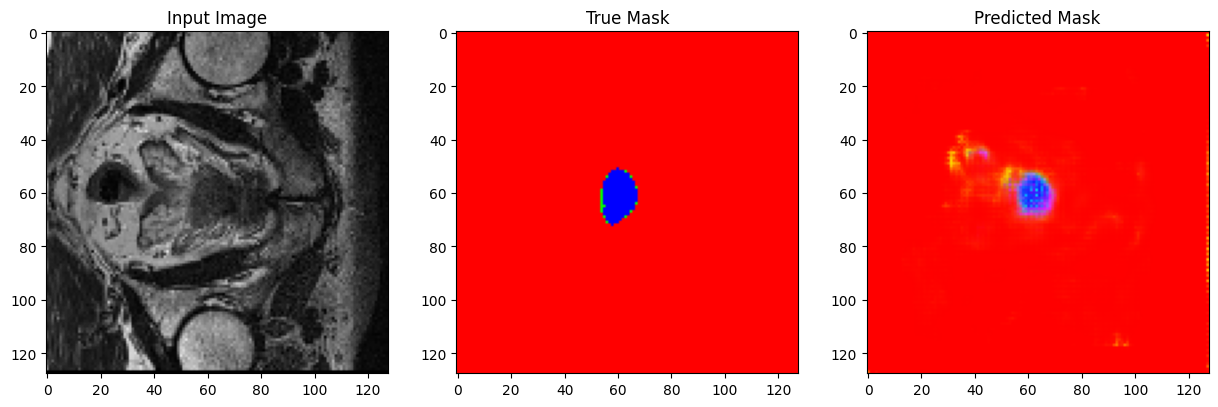

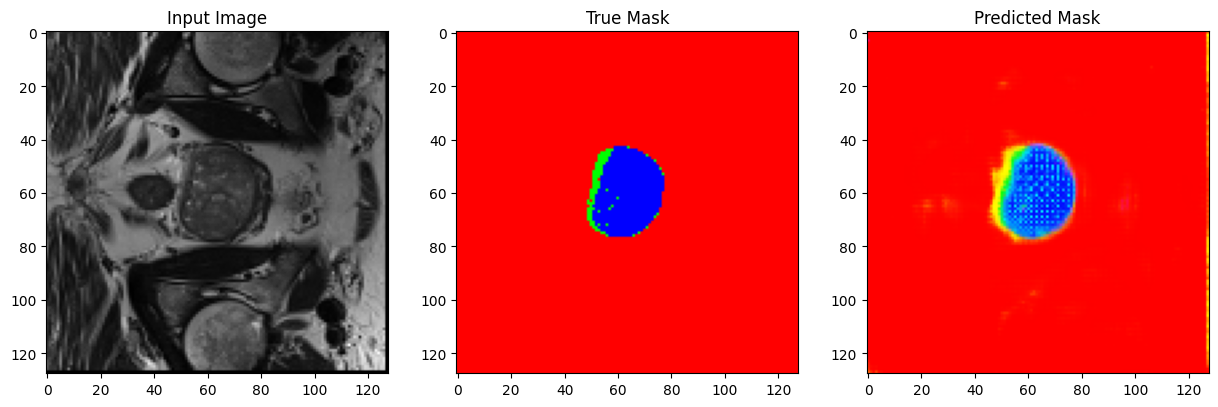

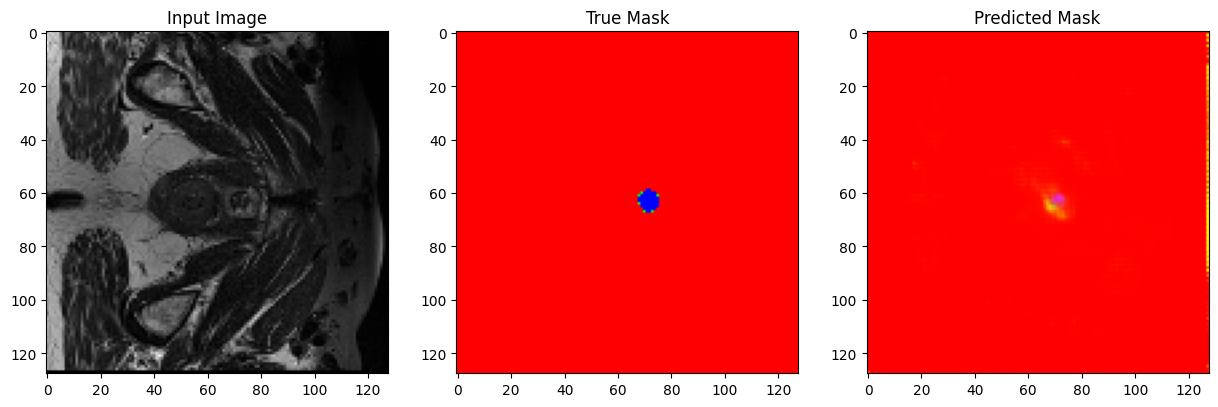

In [12]:
import matplotlib.pyplot as plt

def plot_sample(X, y_true, y_pred, index):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    axes[0].imshow(X[index].squeeze(), cmap='gray')
    axes[0].set_title('Input Image')

    axes[1].imshow(y_true[index].squeeze(), cmap='gray')
    axes[1].set_title('True Mask')

    axes[2].imshow(y_pred[index].squeeze(), cmap='gray')
    axes[2].set_title('Predicted Mask')

    plt.show()

# Get predictions
y_pred = model.predict(X_val)

# Plot a few samples
for i in range(3):
    plot_sample(X_val, y_val, y_pred, i)

In [13]:
# Save the model to a file
model.save('unet_model.keras')

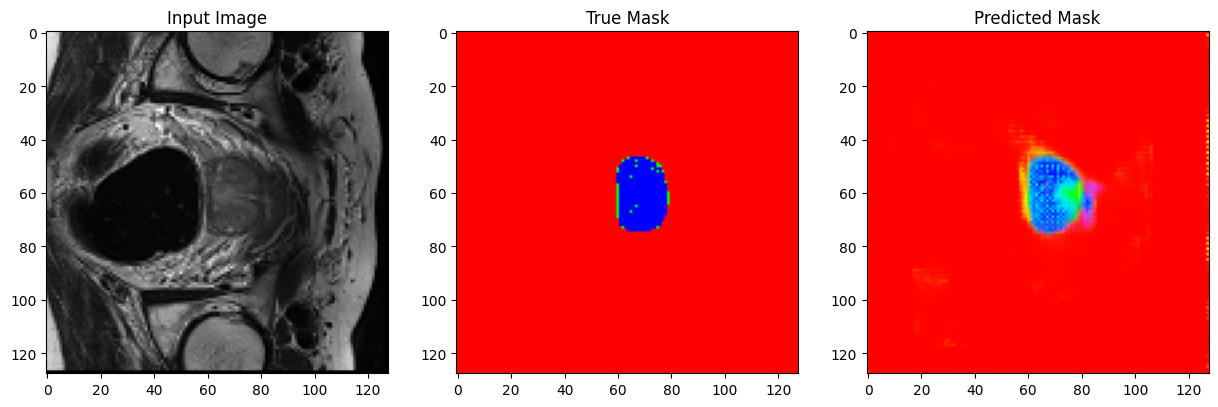

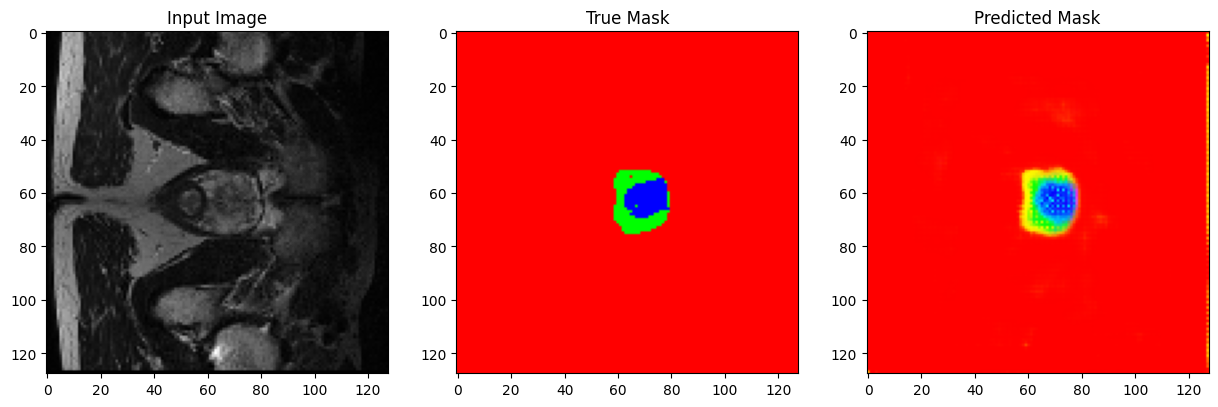

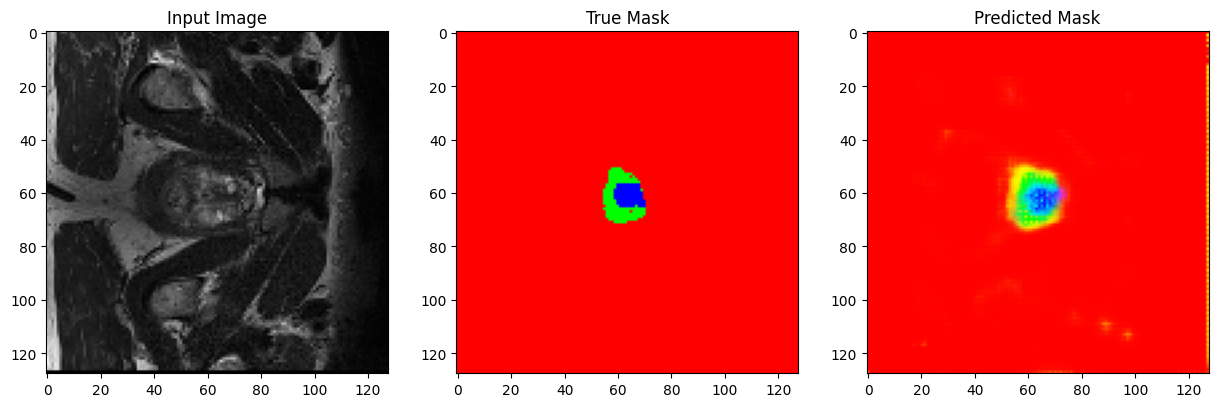

In [15]:
for i in range(3):
    plot_sample(X_val, y_val, y_pred, i+6)

In [21]:
from tensorflow.keras.utils import  plot_model


In [18]:
!pip install pydot

In [22]:
plot_model(model, to_file='unet_model.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [1]:
from IPython.display import Image


In [2]:
Image(filename='unet_model.png')


FileNotFoundError: [Errno 2] No such file or directory: 'unet_model.png'